Seg-Zero
====

**Seg-Zero: Reasoning-Chain Guided Segmentation via Cognitive Reinforcement**

* Paper: https://arxiv.org/abs/2503.06520


![Seg-Zero Overview](../assets/segzero_arch.jpg)


## Installation


```bash
git clone https://github.com/dvlab-research/Seg-Zero.git SegZero_repo
cd SegZero_repo
conda create -n segzero python=3.12 -y
conda activate segzero
pip install torch==2.6.0 torchvision==0.21.0
pip install -e .
```

## Download models

```bash
mkdir pretrained_models
cd pretrained_models
git lfs install
git clone https://huggingface.co/Ricky06662/VisionReasoner-7B
```

In [ ]:
import os
import json
import pdb
import re
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import torch
from PIL import Image as PILImage
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
import matplotlib.pyplot as plt

from transformers import Qwen2VLForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info


/home/pyml/anaconda3/envs/segzero/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
reasoning_model_path = "SegZero_repo/pretrained_models/VisionReasoner-7B"
segmentation_model_path = "facebook/sam2-hiera-large"

In [4]:
reasoning_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    reasoning_model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

segmentation_model = SAM2ImagePredictor.from_pretrained(segmentation_model_path)

reasoning_model.eval()

# default processer
processor = AutoProcessor.from_pretrained(reasoning_model_path, padding_side="left")

print("User question: ", text)

QUESTION_TEMPLATE = \
    "Please find \"{Question}\" with bboxs and points." \
    "Compare the difference between object(s) and find the most closely matched object(s)." \
    "Output the thinking process in <think> </think> and final answer in <answer> </answer> tags." \
    "Output the bbox(es) and point(s) inside the interested object(s) in JSON format." \
    "i.e., <think> thinking process here </think>" \
    "<answer>{Answer}</answer>"

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


User question:  Which plant is taller?


In [6]:
text = "Which plant is taller?"
image_path = "../samples/plants.jpg"

image = PILImage.open(image_path).convert("RGB")
original_width, original_height = image.size
resize_size = 840
x_factor, y_factor = original_width/resize_size, original_height/resize_size
print(f"Original image size: {original_width} x {original_height}")
print("x_factor:", x_factor, "y_factor:", y_factor)

Original image size: 1068 x 1137
x_factor: 1.2714285714285714 y_factor: 1.3535714285714286


In [8]:

messages = []
message = [{
    "role": "user",
    "content": [
    {
        "type": "image", 
        "image": image.resize((resize_size, resize_size), PILImage.BILINEAR)
    },
    {   
        "type": "text",
        "text": QUESTION_TEMPLATE.format(
            Question=text.lower().strip("."),
            Answer=(
                "[{\"bbox_2d\": [10,100,200,210], \"point_2d\": [30,110]}, {\"bbox_2d\": "
                "[225,296,706,786], \"point_2d\": [302,410]}]"
            )
        )    
    }
]
}]
messages.append(message)

# Preparation for inference
text = [processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True) for msg in messages]

#pdb.set_trace()
image_inputs, video_inputs = process_vision_info(messages)
#pdb.set_trace()
inputs = processor(
    text=text,
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [10]:
def extract_bbox_points_think(output_text, x_factor, y_factor):
    json_match = re.search(r'<answer>\s*(.*?)\s*</answer>', output_text, re.DOTALL)
    if json_match:
        data = json.loads(json_match.group(1))
        pred_bboxes = [[
            int(item['bbox_2d'][0] * x_factor + 0.5),
            int(item['bbox_2d'][1] * y_factor + 0.5),
            int(item['bbox_2d'][2] * x_factor + 0.5),
            int(item['bbox_2d'][3] * y_factor + 0.5)
        ] for item in data]
        pred_points = [[
            int(item['point_2d'][0] * x_factor + 0.5),
            int(item['point_2d'][1] * y_factor + 0.5)
        ] for item in data]
    
    think_pattern = r'<think>([^<]+)</think>'
    think_match = re.search(think_pattern, output_text)
    think_text = ""
    if think_match:
        think_text = think_match.group(1)
    
    return pred_bboxes, pred_points, think_text

In [11]:
# Inference: Generation of the output
generated_ids = reasoning_model.generate(
    **inputs, use_cache=True, max_new_tokens=1024, do_sample=False
)

generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text[0])
# pdb.set_trace()
bboxes, points, think = extract_bbox_points_think(output_text[0], x_factor, y_factor)
print(points, len(points))

print("Thinking process: ", think)

<think> To determine which plant is taller, I need to compare the height of the plants relative to their pots. The plant on the right appears to have a taller stem and larger leaves, suggesting it is taller than the plant on the left. The pots themselves are the same height, so the difference in height is due to the plants themselves.</think>
<answer>[{"bbox_2d": [337,56,620,587], "point_2d": [510,280]}, {"bbox_2d": [107,354,364,664], "point_2d": [218,470]}]</answer>
[[648, 379], [277, 636]] 2
Thinking process:   To determine which plant is taller, I need to compare the height of the plants relative to their pots. The plant on the right appears to have a taller stem and larger leaves, suggesting it is taller than the plant on the left. The pots themselves are the same height, so the difference in height is due to the plants themselves.


In [13]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    mask_all = np.zeros((image.height, image.width), dtype=bool)
    segmentation_model.set_image(image)
    for bbox, point in zip(bboxes, points):
        masks, scores, _ = segmentation_model.predict(
            point_coords=[point],
            point_labels=[1],
            box=bbox
        )
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        mask = masks[0].astype(bool)
        mask_all = np.logical_or(mask_all, mask)

print("Final detected mask shape:", mask_all.shape)

Final detected mask shape: (1137, 1068)


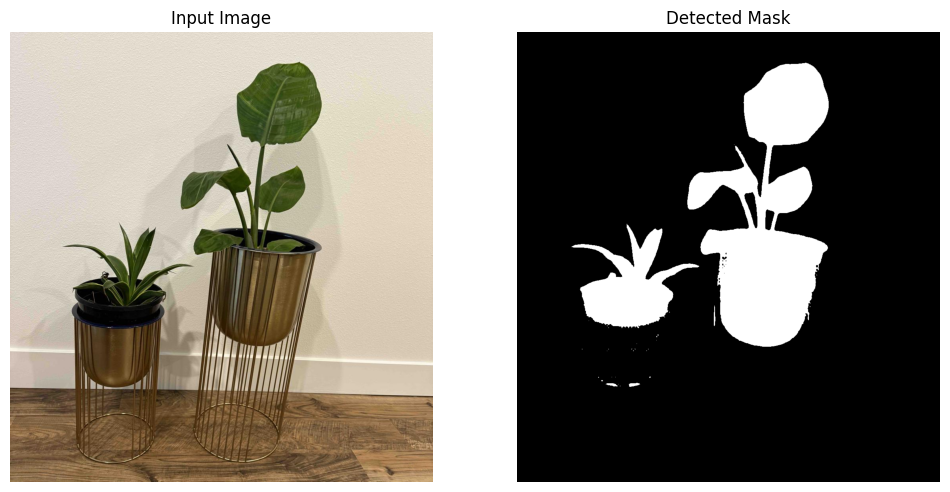

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")
axes[1].imshow(mask_all, cmap="gray")
axes[1].set_title("Detected Mask")
axes[1].axis("off")
plt.show()